 Code for the introductory example in our paper

In [6]:
import cuqi
assert cuqi.__version__ == '0.3.0'

from cuqi.testproblem import Deconvolution2D
from cuqi.distribution import Gaussian, Laplace_diff, Gamma
from cuqi.problem import BayesianProblem
from cuqi.data import imresize, rgb2gray

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0) # for reproducibility
hyperparameters = True # if True, use hyperparameters, else use fixed parameters

In [7]:
# Load cookie.png from current folder.
cookie = plt.imread('cookie2.png')

# Convert to rgb.
cookie = cookie[:, :, :3]

# Convert to grayscale.
cookie = rgb2gray(cookie)

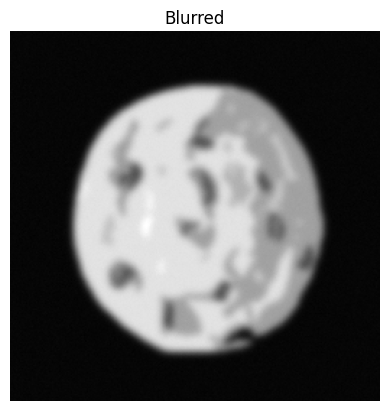

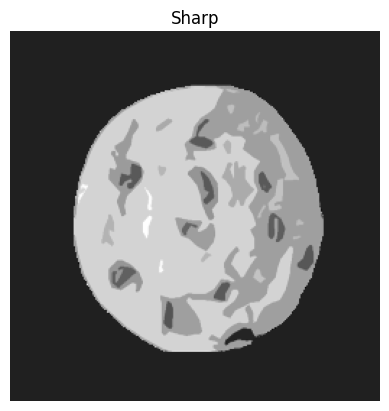

In [8]:
A, y_data, info = Deconvolution2D.get_components(dim=256, phantom=cookie)
y_data.plot(); plt.axis('off'); plt.title('Blurred'); plt.show()
info.exactSolution.plot(); plt.axis('off'); plt.title('Sharp'); plt.show()

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Gibbs sampler
burn-in: 20%

Automatically determined sampling strategy:
	x: UnadjustedLaplaceApproximation
	d: ConjugateApprox
	s: Conjugate

Warmup 200 / 200
Sample 1000 / 1000
Elapsed time: 903.6169550418854
Plotting results


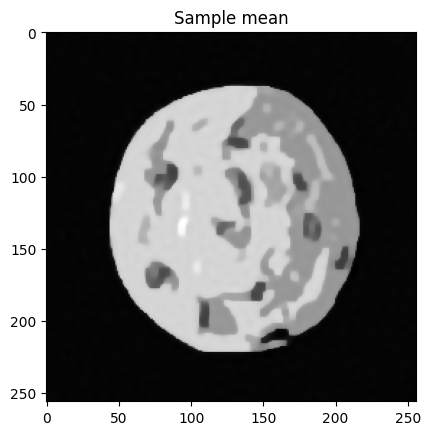

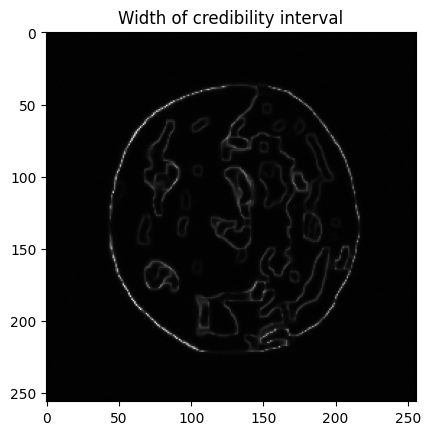

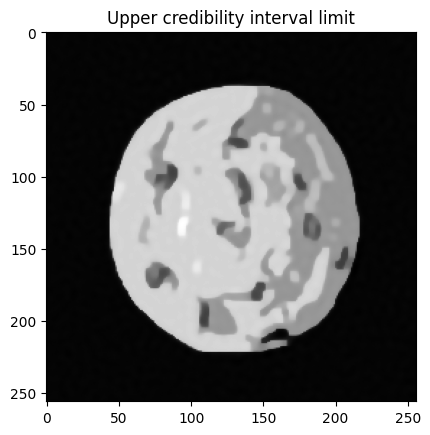

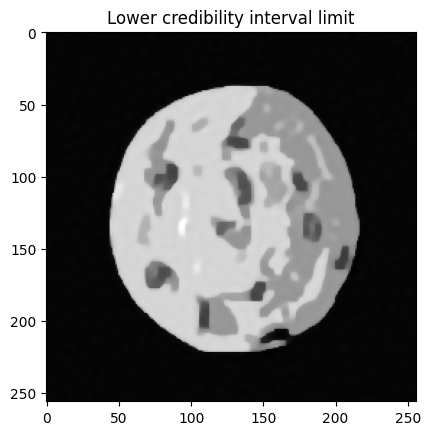

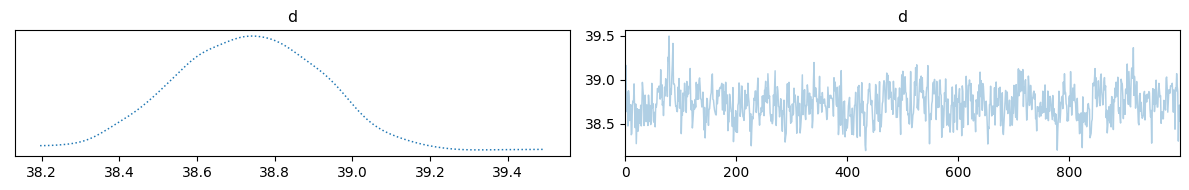

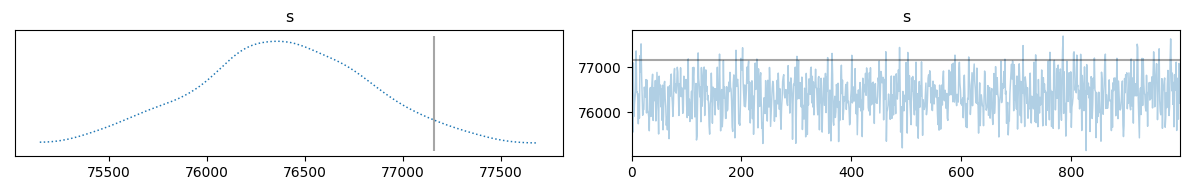

In [9]:
# Bayesian problem.
if not hyperparameters:
    x = Laplace_diff(np.zeros(A.domain_dim), 0.1, physical_dim=2)
    y = Gaussian(A @ x, 0.0036**2)
    BP = BayesianProblem(x, y)
    BP.set_data(y=y_data)
    samples = BP.UQ(1000)
    samples = {"x": samples} # For compatibility with the next cell.
else:
    d = Gamma(1, 1e-4)
    s = Gamma(1, 1e-4)
    x = Laplace_diff(np.zeros(A.domain_dim), lambda d: 1/d, physical_dim=2)
    y = Gaussian(A @ x, lambda s: 1/s)
    BP = BayesianProblem(x, y, d, s)
    BP.set_data(y=y_data)
    samples = BP.UQ(1000, exact={"s": 1/(0.0036**2)})

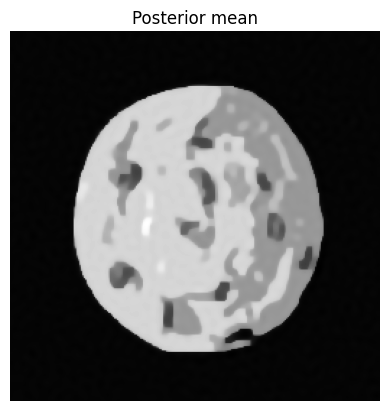

In [10]:
samples["x"].plot_mean(); plt.title('Posterior mean'); plt.axis('off'); plt.show()

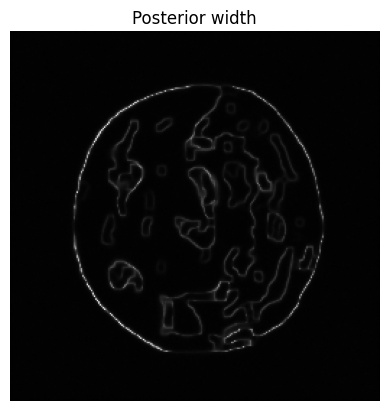

In [11]:
samples["x"].plot_ci_width(); plt.title('Posterior width'); plt.axis('off'); plt.show()

In [16]:
# Print nicely statistics of s and d. Only works if hyperparameters=True.
# We print the mean, lower and upper 99% confidence interval.
if hyperparameters:
    print(f"{'':<10} {'mean':<10} {'lower':<10} {'upper':<10} {'actual':<10}")
    print(f"{'-'*10} {'-'*10} {'-'*10} {'-'*10} {'-'*10}")
    for key in ["s", "d"]:
        mean = samples[key].mean()
        lower, upper = samples[key].compute_ci(99)
        if key == "s":
            actual = 1/(0.0036**2)
            print(f"{key:<10} {mean[0]:<10.3e} {lower[0]:<10.3e} {upper[0]:<10.3e} {actual:<10.3e}")
        else:
            print(f"{key:<10} {mean[0]:<10.3e} {lower[0]:<10.3e} {upper[0]:<10.3e} {'-':<10}")

           mean       lower      upper      actual    
---------- ---------- ---------- ---------- ----------
s          7.638e+04  7.535e+04  7.744e+04  7.716e+04 
d          3.873e+01  3.827e+01  3.920e+01  -         
